In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import itertools
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import numpy as np
from coin_detector import crop_coin
import pandas as pd


# Circles

In [3]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

NameError: name 'create_circular_mask' is not defined

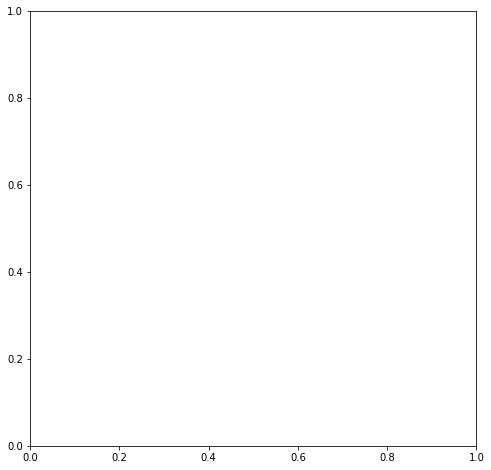

In [39]:
name = './339_2.jpg'

height_img_ds = 500

img_orig = cv2.imread(name)

ds_ratio = height_img_ds/img_orig.shape[0] 
img_ds = cv2.resize(img_orig, None, fx=ds_ratio, fy=ds_ratio, interpolation=cv2.INTER_AREA) # downsampling

gray = cv2.cvtColor(img_ds, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (3, 3), 0)

thresh = cv2.Canny(gray, 50, 100)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)


circles = cv2.HoughCircles(closed, cv2.HOUGH_GRADIENT, 1, minDist=img_ds.shape[0], param1=100, param2=0.9, minRadius=int(0.35 * img_ds.shape[0]))
circles = circles[0,:]
(x, y, r) = max(circles, key=lambda c: c[2])
x, y, r = x/ds_ratio, y/ds_ratio, r/ds_ratio

fig, ax = plt.subplots(figsize=(8, 8))
# ax.add_patch(plt.Circle((x, y), int(r), color='r', fill=Falselogo_single.png))

img_crop = img_orig[int(y-r):int(y+r), int(x-r):int(x+r)]
mask = create_circular_mask(img_crop.shape[0], img_crop.shape[0])
masked_img = img_crop.copy()
masked_img[~mask] = 0

ax.imshow(masked_img)
plt.show()

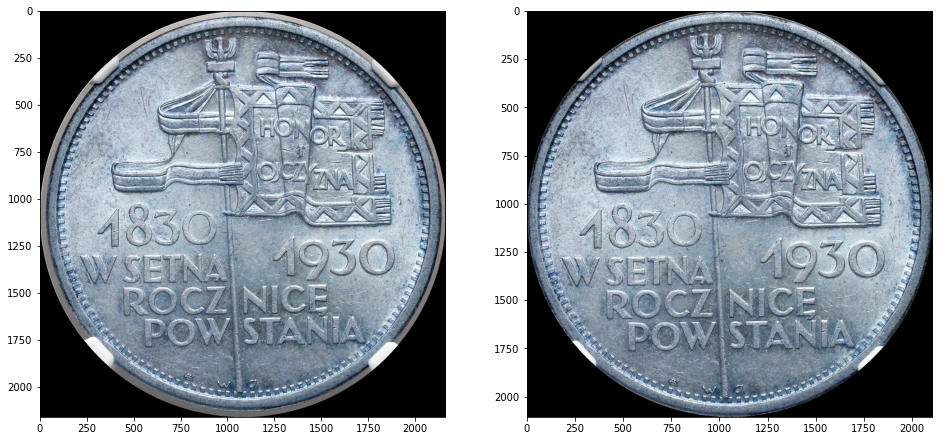

In [46]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))
img_orig = cv2.imread('./33_1.jpg')
im_1 = crop_coin(img_orig, height_img_ds=800, hough_param2=0.5)
im_2 = im_1[10:, 10:]
im_2 = crop_coin(im_2, height_img_ds=800, hough_param2=0.5, mc_size=(5, 5))
ax1.imshow(im_1)
ax2.imshow(im_2)
plt.show()

30.0
26.77777777777778
23.555555555555557
20.333333333333336
17.11111111111111


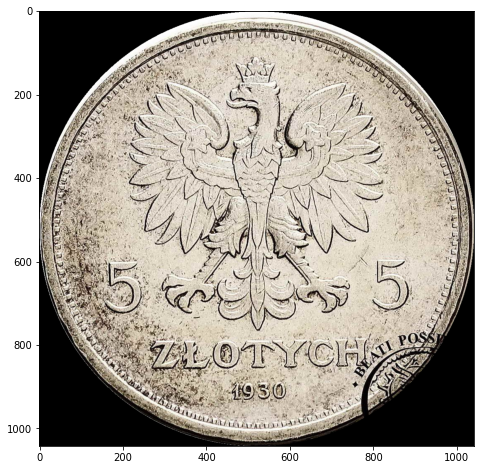

In [62]:
root = "../dataset/niemczyk/img/sztandar_1930"
name = './406_2.jpg'

fig, ax = plt.subplots(figsize=(8, 8))
im = cv2.imread(root + "/" + name)
im = crop_coin(im, height_img_ds=800, hough_param2=30, canny_th1=40, canny_th2=80)
ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
root = "../dataset/niemczyk/img/sztandar_1930"
df = pd.read_csv(root + "/labels.csv")
# df = df[150:]
for name in df[df["label"] > 0]["name"]:
    print(name)
    try:
        img = cv2.imread(root + "/" + name)
        # crop = crop_coin(img, height_img_ds=800, hough_param2=0.8)
        crop = crop_coin(img, height_img_ds=800, hough_param2=0.8, canny_th1=40, canny_th2=80)
        cv2.imwrite(root + "/cropped/" + name, crop)
    except:
        print('error')
        pass

162_3.jpg
163_1.jpg
163_2.jpg
164_1.jpg
164_2.jpg
165_1.jpg
165_2.jpg
166_1.jpg
166_2.jpg
167_1.jpg
167_2.jpg
168_1.jpg
168_2.jpg
169_1.jpg
169_2.jpg
16_2.jpg
16_3.jpg
170_2.jpg
171_2.jpg
172_1.jpg
172_2.jpg
173_1.jpg
173_2.jpg
174_1.jpg
174_2.jpg
175_1.jpg
175_2.jpg
176_1.jpg
176_2.jpg
177_1.jpg
177_2.jpg
178_1.jpg
178_2.jpg
179_1.jpg
179_2.jpg
17_2.jpg
17_3.jpg
180_1.jpg
180_2.jpg
181_2.jpg
181_3.jpg
182_1.jpg
182_2.jpg
183_1.jpg
183_2.jpg
184_1.jpg
184_2.jpg
185_1.jpg
185_2.jpg
186_1.jpg
186_2.jpg
187_2.jpg
188_1.jpg
188_2.jpg
189_1.jpg
189_2.jpg
18_1.jpg
18_2.jpg
190_1.jpg
190_2.jpg
191_1.jpg
191_2.jpg
192_1.jpg
192_2.jpg
193_1.jpg
193_2.jpg
194_1.jpg
194_2.jpg
195_1.jpg
195_2.jpg
196_1.jpg
196_2.jpg
197_1.jpg
197_2.jpg
198_1.jpg
198_2.jpg
199_1.jpg
199_2.jpg
19_1.jpg
19_2.jpg
1_1.jpg
1_2.jpg
200_1.jpg
200_2.jpg
201_1.jpg
201_2.jpg
202_1.jpg
202_2.jpg
203_1.jpg
203_2.jpg
204_2.jpg
204_3.jpg
205_1.jpg
205_2.jpg
206_1.jpg
206_2.jpg
20_2.jpg
20_3.jpg
210_1.jpg
210_2.jpg
211_1.jpg
211_

Errors:

Marciniak

127_2


# Ellipses

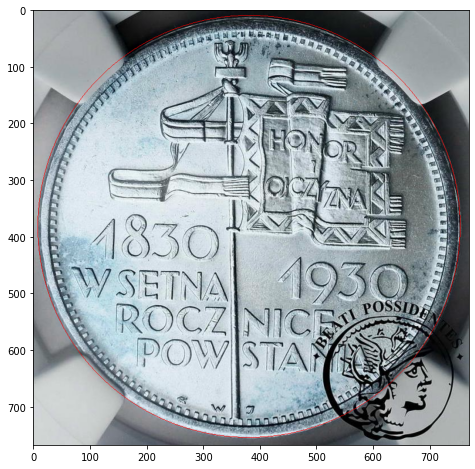

In [9]:
name = './339_2.jpg'
height_img_ds = 500

img_orig = cv2.imread(name)

ds_ratio = height_img_ds/img_orig.shape[0] 
img_ds = cv2.resize(img_orig, None, fx=ds_ratio, fy=ds_ratio, interpolation=cv2.INTER_AREA) # downsampling

gray = cv2.cvtColor(img_ds, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (3, 3), 0)

thresh = cv2.Canny(gray, 50, 100)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

_, th = cv2.threshold(closed, 1, 1, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(th, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
max_contour = max(contours, key=cv2.contourArea)
img_max_contour = cv2.drawContours(np.zeros(gray.shape), max_contour, -1, (255,255,255), 1)

elipses = hough_ellipse(img_max_contour, accuracy=30, threshold=100, min_size=int(0.4 * closed.shape[0]))
elipses.sort(order='accumulator')
best_ellipse = list(elipses[-1])
(yc, xc, a, b), orientation = [int(round(x/ds_ratio)) for x in best_ellipse[1:5]], best_ellipse[5]
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
img_orig[cy, cx] = (250, 0, 0)

fig, ax = plt.subplots( figsize=(8, 8))
ax.imshow(img_orig)
plt.show()